# Methods SWMT example figure

In [1]:
import glob
import dask.distributed
import gsw
import numpy as np
import xarray as xr
import pandas as pd
from scipy.signal import detrend
import cf_xarray as cfxr
import xesmf as xe

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean.cm as cmo
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.path as mpath
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import string
import calendar

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)

In [3]:
# Import the example data
pan01_C_swmt = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/plots/swmt_shelf_sum_ave_rho0_C_pan01.nc', chunks = 'auto') 

In [4]:
# 25-75% limits
pan01_25 = 27.89
pan01_75 = 27.73 

''

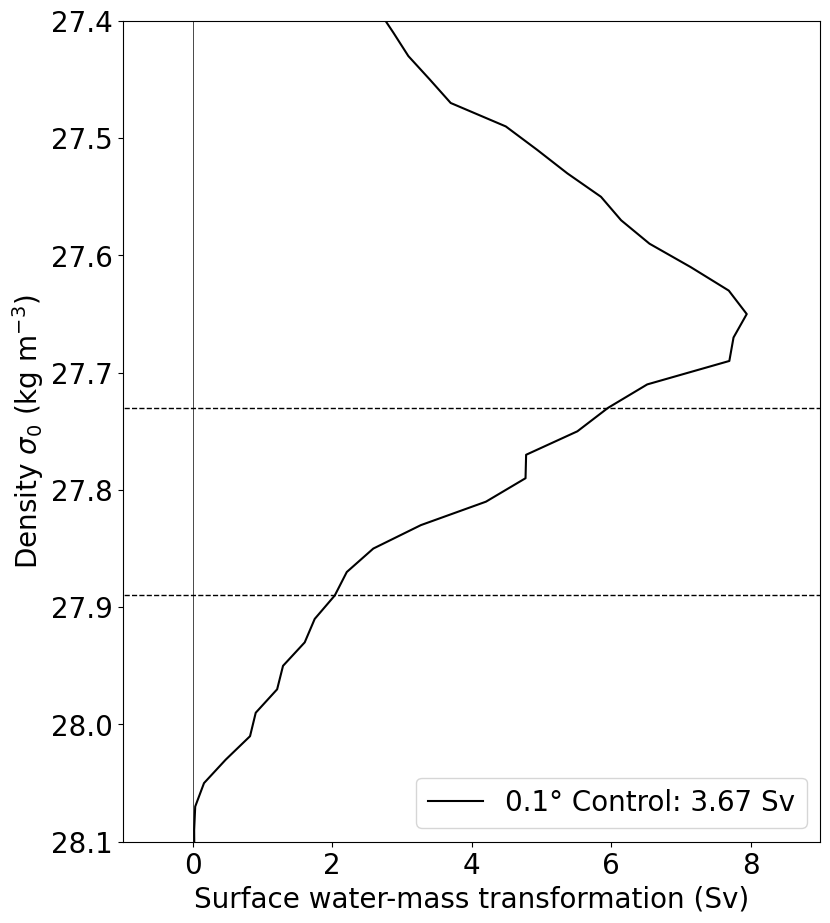

In [7]:
plt.rcParams['font.size'] = 20

fig, ax1 = plt.subplots(figsize=(9, 10.66))

ax1.plot(pan01_C_swmt, pan01_C_swmt['isopycnal_bins'], linestyle='-', color = 'black', label='0.1° Control: 3.67 Sv')

ax1.plot([0, 0], [27.4, 28.1], 'k', linewidth=0.5)
ax1.plot([-5, 15], [pan01_25, pan01_25], 'k--', linewidth=1)
ax1.plot([-5, 15], [pan01_75, pan01_75], 'k--', linewidth=1)

leg = plt.legend()
# Access the text objects in the legend
for text, color in zip(leg.get_texts(), ['black', 'black','#E50000','#E50000']):
    text.set_color(color)

ax1.set_ylim((28.1, 27.4))
ax1.set_xlim((-1, 9))
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
ax1.set_ylabel('Density $\sigma_0$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
;

# Formation regions plot

In [5]:
deptho = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho'].sel(yh=slice(None,-50))
xh = deptho['xh']
yh = deptho['yh']

In [6]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [7]:
land_mask = (0 * deptho).fillna(1)
land = xr.where(np.isnan(deptho.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(deptho, 'mom6_01')

In [8]:
def mask_from_polygon(lon, lat, xh, yh):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xh, yh)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xh.size, yh.size).transpose()
    mask = xr.DataArray(
    mask, dims=['yh', 'xh'],
    coords={'xh': xh, 'yh': yh})
    return mask

In [9]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'sig0_bins': [27.92, 27.81, 27.81, 28],
    'ind_iso_min': [3647, 5151, 581, 1141],
    'ind_iso_max': [4307, 134, 960, 1830],
    'sector': [[-65, 0, -78.5,  -62],
               [45, 80, -70, -60],
               [125-360, 165-360, -70, -60],
               [150-360, 220-360, -79, -65]],
    'mask_taux_lon': [[-58.5, -51, -36, -20, -20, -38, -58.5],
                      [35, 35, 80, 80, -280, -280, -230, -230],
                      [-225, -225, -210, -197, -197, -225],
                      [-171, -171, -140, -80, -80, -172]],
    'mask_taux_lat': [[-76.5, -72, -67.5, -69, -74, -78.8, -76.5],
                      [-65, -58, -58, -65, -65, -58, -58, -65],
                      [-67, -65, -65, -67.5, -71.8, -67],
                      [-79, -75, -67 , -67, -76, -79]]}

In [10]:
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_DSW = mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xh, yh).expand_dims(area=['Weddell'])
    else:
        mask_DSW = xr.concat((mask_DSW, mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xh, yh).expand_dims(area=[area_text])), dim='area')
    mask_DSW, shelf_mask = shelf_mask_isobath(mask_DSW, 'mom6_01')
mask_DSW = mask_DSW.where(mask_DSW == True)
mask_DSW = mask_DSW.where(land_mask == 0)
mask_DSW = mask_DSW .where(mask_DSW == 1, 0)

In [11]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

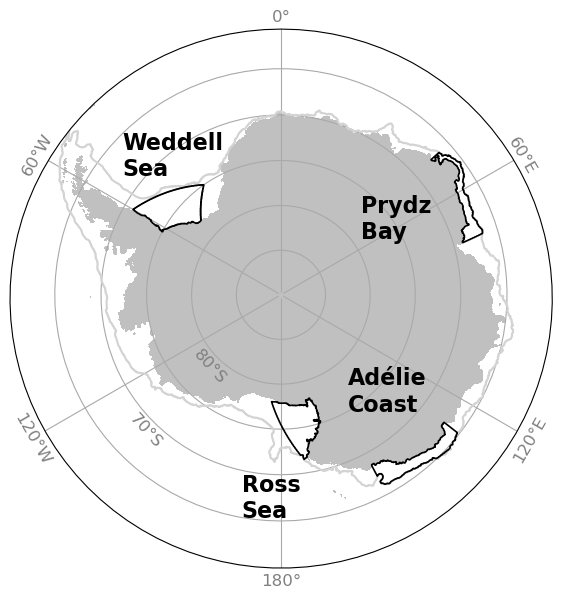

In [16]:
fig = plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=.3)
proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], proj)
ax.set_boundary(circle, transform=ax.transAxes)

# Land mask
ax.contourf(land_mask.xh.values,
            np.concatenate(([-90], land_mask.yh[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2)

# Gridlines
gl = ax.gridlines(draw_labels=False, color='darkgray', zorder=3)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 60))

label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5]
for i, position in enumerate([0, 180, 60, -120, 120, -60]):
    ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            ha='center', va='center',
            color='gray', fontsize=12, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax.text(-135, -j+1.3, label, rotation=-48, ha='center',
            va='center', color='gray', fontsize=12,
            transform=proj)

# Formation region contours
plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Weddell').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)

plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Ross').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)


plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Prydz').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)


plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Adelie').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)


# Shelf contour
plt.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask.values,
            levels=[0, 1], colors='lightgray', linewidth=.7,
            transform=proj)

plt.text(-53, -68, 'Weddell\nSea', fontweight='bold', transform=proj, fontsize =16)
plt.text(55, -79, 'Prydz\nBay', fontweight='bold', transform=proj, fontsize =16)
plt.text(150, -75, 'Adélie\nCoast', fontweight='bold', transform=proj, fontsize =16)
plt.text(-170, -65, 'Ross\nSea', fontweight='bold', transform=proj, fontsize =16)


plt.show()


# Combining into one figure

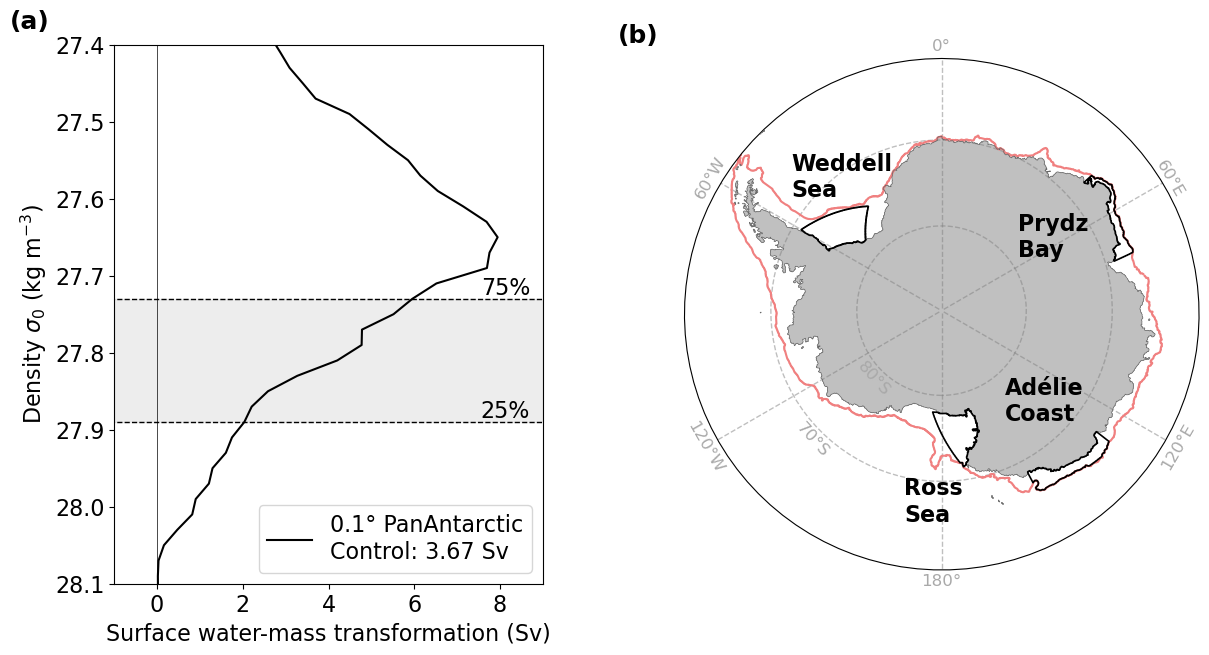

In [13]:
plt.rcParams['font.size'] = 16

# --- Create figure and grid ---
fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2], wspace=0.3)
proj = ccrs.PlateCarree()

# ===============================
# Panel (a): SWMT vs density
# ===============================
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(pan01_C_swmt, pan01_C_swmt['isopycnal_bins'], linestyle='-', color='black', label='0.1° PanAntarctic\nControl: 3.67 Sv')

ax1.plot([0, 0], [27.4, 28.1], 'k', linewidth=0.5)
ax1.plot([-5, 15], [pan01_25, pan01_25], 'k--', linewidth=1)
ax1.plot([-5, 15], [pan01_75, pan01_75], 'k--', linewidth=1)

# --- Shading between them ---
ax1.fill_betweenx(
    y=[pan01_25, pan01_75],
    x1=-1, x2=9,                 # match your x-limits
    color='lightgray', alpha=0.4, zorder=0
)

# Add text labels for 25% and 75%
ax1.text(8.7, pan01_25 + 0.001, '25%', ha='right', va='bottom', fontsize=16)
ax1.text(8.7, pan01_75 + 0.001, '75%', ha='right', va='bottom', fontsize=16)

leg = ax1.legend(loc='lower right')
ax1.set_ylim((28.1, 27.4))
ax1.set_xlim((-1, 9))
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
ax1.set_ylabel('Density $\sigma_0$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')

# Panel label
ax1.text(-0.15, 1.02, '(a)', transform=ax1.transAxes, fontsize=18, fontweight='bold', va='bottom', ha='right')

# ===============================
# Panel (b): Map of formation regions
# ===============================
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.SouthPolarStereo())
ax2.set_extent([-180, 180, -90, -60], proj)
ax2.set_boundary(circle, transform=ax2.transAxes)

# Land mask
ax2.contourf(land_mask.xh.values,
             np.concatenate(([-90], land_mask.yh[1:].values)),
             land_mask, colors='silver', levels=[0.5, 2],
             transform=proj, rasterized=True, zorder=2)

# Gridlines
#gl = ax2.gridlines(draw_labels=False, color='darkgray', zorder=3)
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 60))

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

# Grid labels
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2]
for i, position in enumerate([0, 180, 60, -120, 120, -60]):
    ax2.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
             ha='center', va='center', color='darkgray', fontsize=12, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax2.text(-135, -j+1.3, label, rotation=-48, ha='center',
             va='center', color='darkgray', fontsize=12,
             transform=proj)

# Formation region contours
for area in ['Weddell', 'Ross', 'Prydz', 'Adelie']:
    plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area=area).values,
                levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)

# Shelf contour
plt.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask.values,
            levels=[0, 1], colors='lightcoral', linewidth=.5,
            transform=proj)

# Coast line
ax2.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
            levels=[0, 1], colors='dimgrey', linewidths=0.5,
            transform=ccrs.PlateCarree(), zorder=3)

# Region labels
plt.text(-53, -68, 'Weddell\nSea', fontweight='bold', transform=proj, fontsize=16)
plt.text(55, -79, 'Prydz\nBay', fontweight='bold', transform=proj, fontsize=16)
plt.text(150, -75, 'Adélie\nCoast', fontweight='bold', transform=proj, fontsize=16)
plt.text(-170, -65, 'Ross\nSea', fontweight='bold', transform=proj, fontsize=16)

# Panel label
ax2.text(-0.05, 1.02, '(b)', transform=ax2.transAxes, fontsize=18, fontweight='bold', va='bottom', ha='right')

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/Methods_SWMT_Definitions.png", dpi=300, bbox_inches='tight')